Created directory: petroleum_optimization_data
=== Generating Synthetic Data ===
Generated 1500 gas lift optimization samples
Data saved: petroleum_optimization_data/gas_lift_data_20250723_135448.csv and petroleum_optimization_data/gas_lift_data_20250723_135448.pkl
Generated 1500 choke optimization samples
Data saved: petroleum_optimization_data/choke_data_20250723_135448.csv and petroleum_optimization_data/choke_data_20250723_135448.pkl

=== Gas Lift Data Statistics ===
       gas_injection_rate  wellhead_pressure  reservoir_pressure    water_cut  \
count         1500.000000        1500.000000         1500.000000  1500.000000   
mean             2.747107         450.300519         2468.098906    47.430042   
std              1.323068         202.562961          855.538077    27.517813   
min              0.520844         100.008144         1000.092157     0.021569   
25%              1.568948         280.179690         1724.498777    23.605290   
50%              2.779528         453.

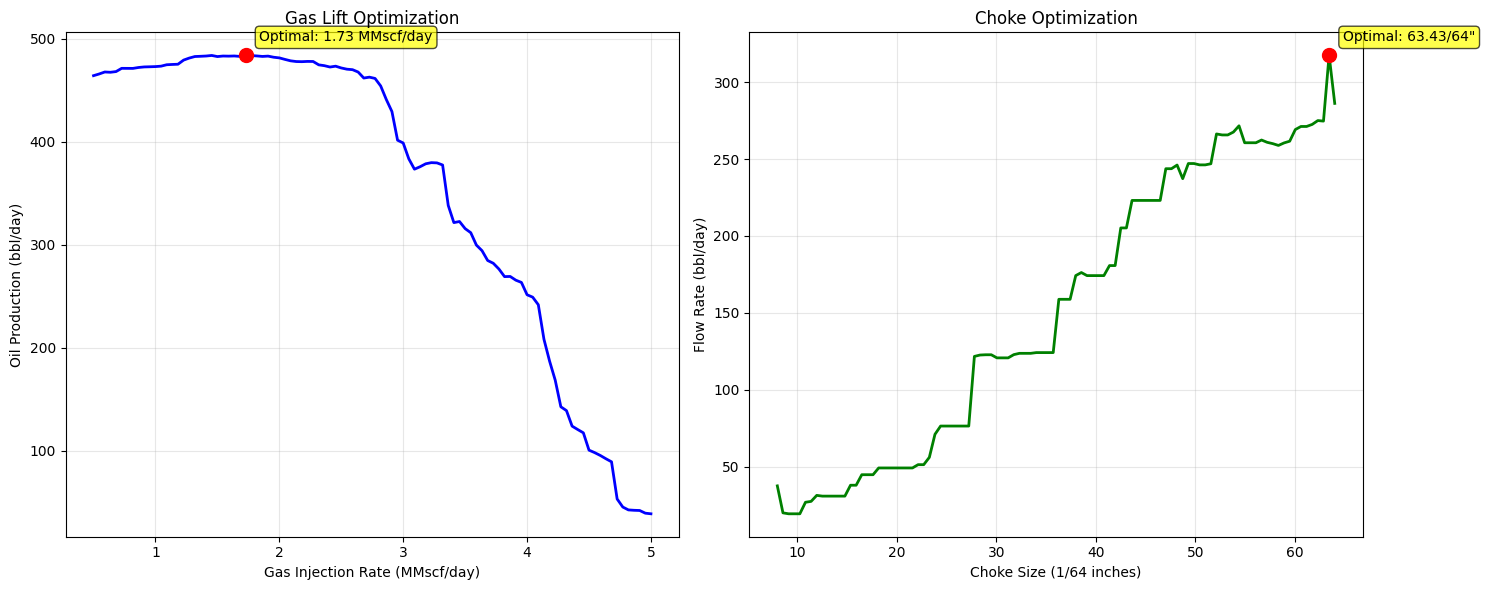

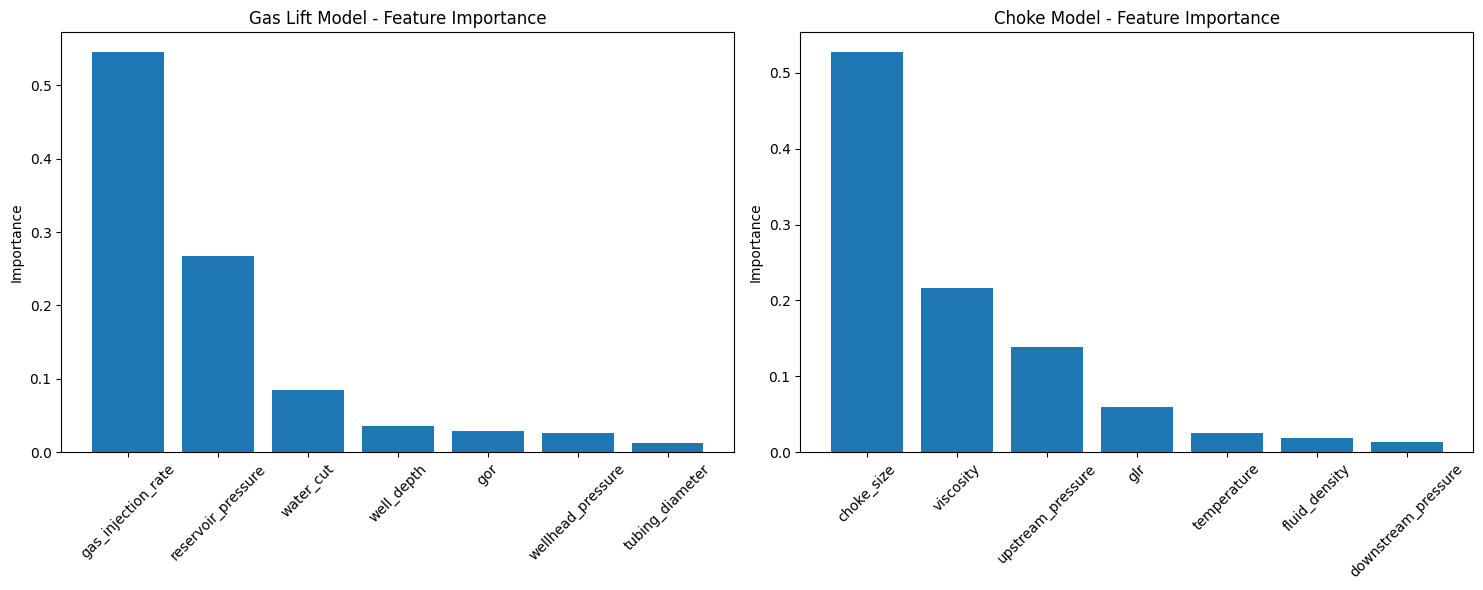


=== Saving Project Summary ===
Project summary saved: petroleum_optimization_data/project_summary.json

=== Saved Files in petroleum_optimization_data ===

Data Files:
  - choke_data_20250723_135448.csv
  - choke_data_20250723_135448.pkl
  - gas_lift_data_20250723_135448.csv
  - gas_lift_data_20250723_135448.pkl

Model Files:
  - choke_model_20250723_140231.pkl
  - gas_lift_model_20250723_135626.pkl

Metadata Files:
  - choke_model_metadata_20250723_140231.json
  - gas_lift_model_metadata_20250723_135626.json

Optimization Results:
  - choke_optimization_results_20250723_140231.json
  - gas_lift_optimization_results_20250723_140231.json

=== Project Complete ===
Gas Lift and Choke Optimization models have been successfully developed!
All data, models, and results have been saved for future use.
The models can now be used for real-time optimization in petroleum production systems.

=== Example: Loading Saved Data ===
To load previously saved data:
1. Use optimizer.list_saved_files() to

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pickle
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class GasLiftChokeOptimizer:
    """
    Gas Lift and Choke Optimization using Machine Learning

    This class handles data generation, model training, and optimization
    for both gas lift and choke systems in petroleum production.
    """

    def __init__(self, save_dir='petroleum_optimization_data'):
        self.gas_lift_model = None
        self.choke_model = None
        self.scaler_gas_lift = StandardScaler()
        self.scaler_choke = StandardScaler()
        self.gas_lift_data = None
        self.choke_data = None
        self.save_dir = save_dir
        self.model_metadata = {}

        # Create save directory if it doesn't exist
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
            print(f"Created directory: {self.save_dir}")

    def generate_gas_lift_data(self, n_samples=1000):
        """
        Generate synthetic gas lift optimization data

        Parameters:
        - Gas injection rate (Mscf/day)
        - Wellhead pressure (psi)
        - Reservoir pressure (psi)
        - Water cut (%)
        - Gas-Oil ratio (scf/bbl)
        - Tubing diameter (inches)
        - Well depth (ft)

        Target: Oil production rate (bbl/day)
        """

        # Generate input features
        gas_injection_rate = np.random.uniform(0.5, 5.0, n_samples)  # MMscf/day
        wellhead_pressure = np.random.uniform(100, 800, n_samples)   # psi
        reservoir_pressure = np.random.uniform(1000, 4000, n_samples)  # psi
        water_cut = np.random.uniform(0, 95, n_samples)  # %
        gor = np.random.uniform(200, 2000, n_samples)  # scf/bbl
        tubing_diameter = np.random.choice([2.375, 2.875, 3.5, 4.5], n_samples)  # inches
        well_depth = np.random.uniform(5000, 15000, n_samples)  # ft

        # Physics-based oil production calculation with realistic relationships
        # Simplified model considering major factors

        # Pressure differential effect
        pressure_diff = reservoir_pressure - wellhead_pressure
        pressure_effect = np.log(pressure_diff / 1000) * 200

        # Gas lift efficiency
        optimal_gas_rate = 1.5 + 0.3 * np.sin(well_depth / 5000)  # Optimal varies with depth
        gas_lift_effect = -50 * (gas_injection_rate - optimal_gas_rate)**2 + 150

        # Water cut penalty
        water_cut_effect = -2 * water_cut + 100

        # GOR effect
        gor_effect = 0.05 * gor

        # Tubing diameter effect
        tubing_effect = tubing_diameter * 30

        # Depth effect (artificial lift requirement increases with depth)
        depth_effect = -0.01 * well_depth + 100

        # Combine effects with some noise
        oil_production = (pressure_effect + gas_lift_effect + water_cut_effect +
                         gor_effect + tubing_effect + depth_effect +
                         np.random.normal(0, 50, n_samples))

        # Ensure positive production rates
        oil_production = np.maximum(oil_production, 10)

        # Create dataframe
        self.gas_lift_data = pd.DataFrame({
            'gas_injection_rate': gas_injection_rate,
            'wellhead_pressure': wellhead_pressure,
            'reservoir_pressure': reservoir_pressure,
            'water_cut': water_cut,
            'gor': gor,
            'tubing_diameter': tubing_diameter,
            'well_depth': well_depth,
            'oil_production': oil_production
        })

        print(f"Generated {n_samples} gas lift optimization samples")

        # Save data automatically
        self.save_data(self.gas_lift_data, 'gas_lift_data')

        return self.gas_lift_data

    def generate_choke_data(self, n_samples=1000):
        """
        Generate synthetic choke optimization data

        Parameters:
        - Choke size (1/64 inches)
        - Upstream pressure (psi)
        - Downstream pressure (psi)
        - Gas-liquid ratio (scf/bbl)
        - Fluid density (lb/ft³)
        - Temperature (°F)
        - Viscosity (cp)

        Target: Flow rate (bbl/day)
        """

        # Generate input features
        choke_size = np.random.uniform(8, 64, n_samples)  # 1/64 inches
        upstream_pressure = np.random.uniform(500, 3000, n_samples)  # psi
        downstream_pressure = np.random.uniform(50, 500, n_samples)  # psi
        glr = np.random.uniform(100, 2000, n_samples)  # scf/bbl
        fluid_density = np.random.uniform(30, 60, n_samples)  # lb/ft³
        temperature = np.random.uniform(100, 250, n_samples)  # °F
        viscosity = np.random.uniform(0.5, 10, n_samples)  # cp

        # Physics-based flow rate calculation using choke flow equations
        # Simplified model based on critical flow through chokes

        # Pressure differential
        pressure_diff = upstream_pressure - downstream_pressure

        # Choke flow coefficient (depends on choke size)
        choke_area = (choke_size / 64)**2  # Normalized area
        flow_coefficient = choke_area * 100

        # Critical flow calculation (simplified)
        critical_flow = flow_coefficient * np.sqrt(pressure_diff / fluid_density)

        # Temperature effect on flow
        temp_effect = np.sqrt(temperature / 200)

        # Viscosity effect
        viscosity_effect = 1 / np.sqrt(viscosity)

        # GLR effect on flow
        glr_effect = 1 + 0.0005 * glr

        # Combine effects
        flow_rate = (critical_flow * temp_effect * viscosity_effect * glr_effect +
                    np.random.normal(0, 50, n_samples))

        # Ensure positive flow rates
        flow_rate = np.maximum(flow_rate, 10)

        # Create dataframe
        self.choke_data = pd.DataFrame({
            'choke_size': choke_size,
            'upstream_pressure': upstream_pressure,
            'downstream_pressure': downstream_pressure,
            'glr': glr,
            'fluid_density': fluid_density,
            'temperature': temperature,
            'viscosity': viscosity,
            'flow_rate': flow_rate
        })

        print(f"Generated {n_samples} choke optimization samples")

        # Save data automatically
        self.save_data(self.choke_data, 'choke_data')

        return self.choke_data

    def train_gas_lift_model(self):
        """Train machine learning model for gas lift optimization"""

        if self.gas_lift_data is None:
            raise ValueError("No gas lift data available. Generate data first.")

        # Prepare features and target
        X = self.gas_lift_data.drop('oil_production', axis=1)
        y = self.gas_lift_data['oil_production']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        X_train_scaled = self.scaler_gas_lift.fit_transform(X_train)
        X_test_scaled = self.scaler_gas_lift.transform(X_test)

        # Train model with hyperparameter tuning
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        self.gas_lift_model = grid_search.best_estimator_

        # Evaluate model
        y_pred = self.gas_lift_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print("\n=== Gas Lift Model Performance ===")
        print(f"R² Score: {r2:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")

        # Save model and metadata
        model_results = {
            'model': self.gas_lift_model,
            'scaler': self.scaler_gas_lift,
            'r2_score': r2,
            'mse': mse,
            'mae': mae,
            'best_params': grid_search.best_params_,
            'feature_importance': dict(zip(X.columns, self.gas_lift_model.feature_importances_)),
            'training_date': datetime.now().isoformat(),
            'data_shape': X.shape
        }

        self.save_model(model_results, 'gas_lift_model')

        return {
            'model': self.gas_lift_model,
            'r2_score': r2,
            'mse': mse,
            'mae': mae,
            'feature_importance': dict(zip(X.columns, self.gas_lift_model.feature_importances_))
        }

    def train_choke_model(self):
        """Train machine learning model for choke optimization"""

        if self.choke_data is None:
            raise ValueError("No choke data available. Generate data first.")

        # Prepare features and target
        X = self.choke_data.drop('flow_rate', axis=1)
        y = self.choke_data['flow_rate']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        X_train_scaled = self.scaler_choke.fit_transform(X_train)
        X_test_scaled = self.scaler_choke.transform(X_test)

        # Train model with hyperparameter tuning
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        gbr = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        self.choke_model = grid_search.best_estimator_

        # Evaluate model
        y_pred = self.choke_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print("\n=== Choke Model Performance ===")
        print(f"R² Score: {r2:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")

        # Save model and metadata
        model_results = {
            'model': self.choke_model,
            'scaler': self.scaler_choke,
            'r2_score': r2,
            'mse': mse,
            'mae': mae,
            'best_params': grid_search.best_params_,
            'feature_importance': dict(zip(X.columns, self.choke_model.feature_importances_)),
            'training_date': datetime.now().isoformat(),
            'data_shape': X.shape
        }

        self.save_model(model_results, 'choke_model')

        return {
            'model': self.choke_model,
            'r2_score': r2,
            'mse': mse,
            'mae': mae,
            'feature_importance': dict(zip(X.columns, self.choke_model.feature_importances_))
        }

    def optimize_gas_lift(self, well_conditions, gas_rate_range=(0.5, 5.0), n_points=100):
        """
        Optimize gas injection rate for maximum oil production

        Parameters:
        well_conditions: dict with wellhead_pressure, reservoir_pressure, water_cut,
                        gor, tubing_diameter, well_depth
        gas_rate_range: tuple of (min, max) gas injection rates to test
        n_points: number of points to evaluate
        """

        if self.gas_lift_model is None:
            raise ValueError("Gas lift model not trained. Train model first.")

        # Create range of gas injection rates
        gas_rates = np.linspace(gas_rate_range[0], gas_rate_range[1], n_points)

        # Prepare input data
        optimization_data = []
        for rate in gas_rates:
            data_point = {
                'gas_injection_rate': rate,
                **well_conditions
            }
            optimization_data.append(data_point)

        optimization_df = pd.DataFrame(optimization_data)

        # Scale features
        X_scaled = self.scaler_gas_lift.transform(optimization_df)

        # Predict oil production
        predicted_production = self.gas_lift_model.predict(X_scaled)

        # Find optimal gas injection rate
        optimal_idx = np.argmax(predicted_production)
        optimal_gas_rate = gas_rates[optimal_idx]
        optimal_production = predicted_production[optimal_idx]

        print(f"\n=== Gas Lift Optimization Results ===")
        print(f"Optimal Gas Injection Rate: {optimal_gas_rate:.2f} MMscf/day")
        print(f"Expected Oil Production: {optimal_production:.2f} bbl/day")

        # Save optimization results
        optimization_results = {
            'optimal_gas_rate': optimal_gas_rate,
            'optimal_production': optimal_production,
            'well_conditions': well_conditions,
            'optimization_date': datetime.now().isoformat(),
            'gas_rates': gas_rates.tolist(),
            'predicted_production': predicted_production.tolist()
        }

        self.save_optimization_results(optimization_results, 'gas_lift_optimization')

        return {
            'optimal_gas_rate': optimal_gas_rate,
            'optimal_production': optimal_production,
            'gas_rates': gas_rates,
            'predicted_production': predicted_production
        }

    def optimize_choke(self, flow_conditions, choke_size_range=(8, 64), n_points=100):
        """
        Optimize choke size for maximum flow rate

        Parameters:
        flow_conditions: dict with upstream_pressure, downstream_pressure, glr,
                        fluid_density, temperature, viscosity
        choke_size_range: tuple of (min, max) choke sizes to test
        n_points: number of points to evaluate
        """

        if self.choke_model is None:
            raise ValueError("Choke model not trained. Train model first.")

        # Create range of choke sizes
        choke_sizes = np.linspace(choke_size_range[0], choke_size_range[1], n_points)

        # Prepare input data
        optimization_data = []
        for size in choke_sizes:
            data_point = {
                'choke_size': size,
                **flow_conditions
            }
            optimization_data.append(data_point)

        optimization_df = pd.DataFrame(optimization_data)

        # Scale features
        X_scaled = self.scaler_choke.transform(optimization_df)

        # Predict flow rate
        predicted_flow = self.choke_model.predict(X_scaled)

        # Find optimal choke size
        optimal_idx = np.argmax(predicted_flow)
        optimal_choke_size = choke_sizes[optimal_idx]
        optimal_flow = predicted_flow[optimal_idx]

        print(f"\n=== Choke Optimization Results ===")
        print(f"Optimal Choke Size: {optimal_choke_size:.2f}/64 inches")
        print(f"Expected Flow Rate: {optimal_flow:.2f} bbl/day")

        # Save optimization results
        optimization_results = {
            'optimal_choke_size': optimal_choke_size,
            'optimal_flow': optimal_flow,
            'flow_conditions': flow_conditions,
            'optimization_date': datetime.now().isoformat(),
            'choke_sizes': choke_sizes.tolist(),
            'predicted_flow': predicted_flow.tolist()
        }

        self.save_optimization_results(optimization_results, 'choke_optimization')

        return {
            'optimal_choke_size': optimal_choke_size,
            'optimal_flow': optimal_flow,
            'choke_sizes': choke_sizes,
            'predicted_flow': predicted_flow
        }

    def plot_optimization_results(self, gas_lift_results=None, choke_results=None):
        """Plot optimization results"""

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Gas lift optimization plot
        if gas_lift_results:
            axes[0].plot(gas_lift_results['gas_rates'],
                        gas_lift_results['predicted_production'],
                        'b-', linewidth=2)
            axes[0].scatter(gas_lift_results['optimal_gas_rate'],
                           gas_lift_results['optimal_production'],
                           color='red', s=100, zorder=5)
            axes[0].set_xlabel('Gas Injection Rate (MMscf/day)')
            axes[0].set_ylabel('Oil Production (bbl/day)')
            axes[0].set_title('Gas Lift Optimization')
            axes[0].grid(True, alpha=0.3)
            axes[0].annotate(f'Optimal: {gas_lift_results["optimal_gas_rate"]:.2f} MMscf/day',
                           xy=(gas_lift_results['optimal_gas_rate'],
                               gas_lift_results['optimal_production']),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

        # Choke optimization plot
        if choke_results:
            axes[1].plot(choke_results['choke_sizes'],
                        choke_results['predicted_flow'],
                        'g-', linewidth=2)
            axes[1].scatter(choke_results['optimal_choke_size'],
                           choke_results['optimal_flow'],
                           color='red', s=100, zorder=5)
            axes[1].set_xlabel('Choke Size (1/64 inches)')
            axes[1].set_ylabel('Flow Rate (bbl/day)')
            axes[1].set_title('Choke Optimization')
            axes[1].grid(True, alpha=0.3)
            axes[1].annotate(f'Optimal: {choke_results["optimal_choke_size"]:.2f}/64"',
                           xy=(choke_results['optimal_choke_size'],
                               choke_results['optimal_flow']),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

        plt.tight_layout()
        plt.show()

    def save_data(self, data, filename):
        """Save data to CSV and pickle formats"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save as CSV
        csv_path = os.path.join(self.save_dir, f"{filename}_{timestamp}.csv")
        data.to_csv(csv_path, index=False)

        # Save as pickle for exact reproduction
        pickle_path = os.path.join(self.save_dir, f"{filename}_{timestamp}.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(data, f)

        print(f"Data saved: {csv_path} and {pickle_path}")

    def save_model(self, model_data, model_name):
        """Save trained model and metadata"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save model
        model_path = os.path.join(self.save_dir, f"{model_name}_{timestamp}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)

        # Save metadata as JSON (excluding the actual model object)
        metadata = {k: v for k, v in model_data.items() if k not in ['model', 'scaler']}
        metadata_path = os.path.join(self.save_dir, f"{model_name}_metadata_{timestamp}.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"Model saved: {model_path}")
        print(f"Metadata saved: {metadata_path}")

    def save_optimization_results(self, results, optimization_type):
        """Save optimization results"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save as JSON
        json_path = os.path.join(self.save_dir, f"{optimization_type}_results_{timestamp}.json")
        with open(json_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Optimization results saved: {json_path}")

    def load_data(self, filename):
        """Load data from pickle file"""
        if not filename.endswith('.pkl'):
            filename += '.pkl'

        file_path = os.path.join(self.save_dir, filename)

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None

        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        print(f"Data loaded from: {file_path}")
        return data

    def load_model(self, filename):
        """Load trained model"""
        if not filename.endswith('.pkl'):
            filename += '.pkl'

        file_path = os.path.join(self.save_dir, filename)

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None

        with open(file_path, 'rb') as f:
            model_data = pickle.load(f)

        print(f"Model loaded from: {file_path}")
        return model_data

    def list_saved_files(self):
        """List all saved files in the directory"""
        if not os.path.exists(self.save_dir):
            print("No save directory found.")
            return

        files = os.listdir(self.save_dir)
        if not files:
            print("No saved files found.")
            return

        print(f"\n=== Saved Files in {self.save_dir} ===")

        # Group files by type
        data_files = [f for f in files if f.endswith('.csv') or ('_data_' in f and f.endswith('.pkl'))]
        model_files = [f for f in files if '_model_' in f and f.endswith('.pkl')]
        metadata_files = [f for f in files if f.endswith('.json') and 'metadata' in f]
        result_files = [f for f in files if f.endswith('.json') and 'results' in f]

        if data_files:
            print("\nData Files:")
            for f in sorted(data_files):
                print(f"  - {f}")

        if model_files:
            print("\nModel Files:")
            for f in sorted(model_files):
                print(f"  - {f}")

        if metadata_files:
            print("\nMetadata Files:")
            for f in sorted(metadata_files):
                print(f"  - {f}")

        if result_files:
            print("\nOptimization Results:")
            for f in sorted(result_files):
                print(f"  - {f}")

    def create_project_summary(self):
        """Create a comprehensive project summary"""
        summary = {
            'project_name': 'Gas Lift and Choke Optimization',
            'creation_date': datetime.now().isoformat(),
            'description': 'Machine Learning-based optimization for petroleum production systems',
            'models': {},
            'datasets': {},
            'optimization_runs': []
        }

        # Add model information
        if self.gas_lift_model is not None:
            summary['models']['gas_lift'] = {
                'algorithm': 'Random Forest Regressor',
                'features': list(self.gas_lift_data.drop('oil_production', axis=1).columns) if self.gas_lift_data is not None else [],
                'target': 'oil_production',
                'trained': True
            }

        if self.choke_model is not None:
            summary['models']['choke'] = {
                'algorithm': 'Gradient Boosting Regressor',
                'features': list(self.choke_data.drop('flow_rate', axis=1).columns) if self.choke_data is not None else [],
                'target': 'flow_rate',
                'trained': True
            }

        # Add dataset information
        if self.gas_lift_data is not None:
            summary['datasets']['gas_lift'] = {
                'samples': len(self.gas_lift_data),
                'features': list(self.gas_lift_data.columns),
                'target_range': [float(self.gas_lift_data['oil_production'].min()),
                               float(self.gas_lift_data['oil_production'].max())]
            }

        if self.choke_data is not None:
            summary['datasets']['choke'] = {
                'samples': len(self.choke_data),
                'features': list(self.choke_data.columns),
                'target_range': [float(self.choke_data['flow_rate'].min()),
                               float(self.choke_data['flow_rate'].max())]
            }

        # Save project summary
        summary_path = os.path.join(self.save_dir, 'project_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)

        print(f"Project summary saved: {summary_path}")
        return summary

    def plot_feature_importance(self):
        """Plot feature importance for both models"""

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Gas lift model feature importance
        if self.gas_lift_model:
            features = list(self.gas_lift_data.drop('oil_production', axis=1).columns)
            importance = self.gas_lift_model.feature_importances_

            # Sort features by importance
            sorted_idx = np.argsort(importance)[::-1]

            axes[0].bar(range(len(features)), importance[sorted_idx])
            axes[0].set_xticks(range(len(features)))
            axes[0].set_xticklabels([features[i] for i in sorted_idx], rotation=45)
            axes[0].set_title('Gas Lift Model - Feature Importance')
            axes[0].set_ylabel('Importance')

        # Choke model feature importance
        if self.choke_model:
            features = list(self.choke_data.drop('flow_rate', axis=1).columns)
            importance = self.choke_model.feature_importances_

            # Sort features by importance
            sorted_idx = np.argsort(importance)[::-1]

            axes[1].bar(range(len(features)), importance[sorted_idx])
            axes[1].set_xticks(range(len(features)))
            axes[1].set_xticklabels([features[i] for i in sorted_idx], rotation=45)
            axes[1].set_title('Choke Model - Feature Importance')
            axes[1].set_ylabel('Importance')

        plt.tight_layout()
        plt.show()

# Example usage and demonstration
if __name__ == "__main__":
    # Initialize optimizer
    optimizer = GasLiftChokeOptimizer()

    # Generate synthetic data
    print("=== Generating Synthetic Data ===")
    gas_lift_data = optimizer.generate_gas_lift_data(1500)
    choke_data = optimizer.generate_choke_data(1500)

    # Display data statistics
    print("\n=== Gas Lift Data Statistics ===")
    print(gas_lift_data.describe())

    print("\n=== Choke Data Statistics ===")
    print(choke_data.describe())

    # Train models
    print("\n=== Training Models ===")
    gas_lift_results = optimizer.train_gas_lift_model()
    choke_results = optimizer.train_choke_model()

    # Example optimization scenarios
    print("\n=== Running Optimization Examples ===")

    # Gas lift optimization example
    well_conditions = {
        'wellhead_pressure': 300,
        'reservoir_pressure': 2500,
        'water_cut': 30,
        'gor': 800,
        'tubing_diameter': 3.5,
        'well_depth': 10000
    }

    gas_lift_opt = optimizer.optimize_gas_lift(well_conditions)

    # Choke optimization example
    flow_conditions = {
        'upstream_pressure': 1500,
        'downstream_pressure': 200,
        'glr': 600,
        'fluid_density': 45,
        'temperature': 180,
        'viscosity': 2.5
    }

    choke_opt = optimizer.optimize_choke(flow_conditions)

    # Plot results
    optimizer.plot_optimization_results(gas_lift_opt, choke_opt)
    optimizer.plot_feature_importance()

    # Save project summary and list all saved files
    print("\n=== Saving Project Summary ===")
    project_summary = optimizer.create_project_summary()
    optimizer.list_saved_files()

    print("\n=== Project Complete ===")
    print("Gas Lift and Choke Optimization models have been successfully developed!")
    print("All data, models, and results have been saved for future use.")
    print("The models can now be used for real-time optimization in petroleum production systems.")

    # Example of loading saved data
    print("\n=== Example: Loading Saved Data ===")
    print("To load previously saved data:")
    print("1. Use optimizer.list_saved_files() to see available files")
    print("2. Use optimizer.load_data('filename') to load datasets")
    print("3. Use optimizer.load_model('filename') to load trained models")
    print("4. Check project_summary.json for complete project overview")